Oz Kilic  
COMP 5118 Project

# Pass optimization

In this notebook, I use the trained model to make suggestions for unsuccesfull passes.

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import tqdm
import csv
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import math
import plotly.express as px
import plotly.graph_objs as go
import warnings


model_file = "model1_24.pt"
n_angle = 24
decision_threshold = 0.6099999999999998 # 0.61
position_tensors_folder = "position_tensors"
dataset_file = "dataset_processed.csv"

dataset = pd.read_csv(dataset_file)

print(dataset.columns)
dataset.describe()

class PassOutcomeModel(nn.Module):
    def __init__(self, hidden_layer_size=512, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(35279, hidden_layer_size)
        self.relu3 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_layer_size, 1)
    
    def forward(self, positions, features):
        positions = self.conv1(positions)
        positions = self.relu1(positions)
        positions = self.drop1(positions)
        positions = self.conv2(positions)
        positions = self.relu2(positions)
        positions = self.pool1(positions)
        positions_flat = self.flat(positions)
        combined = torch.cat((positions_flat.to(torch.float32), features.to(torch.float32)), dim=1)
        if positions.is_cuda:
            combined = combined.to("cuda")
        combined = self.fc1(combined)
        combined = self.relu3(combined)
        combined = self.drop2(combined)
        combined = self.fc2(combined)
        return combined.reshape(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load(model_file)
model.to(device).eval()

Index(['match_id', 'id', 'pass_length', 'pass_height_ground',
       'pass_height_low', 'pass_height_high', 'pass_angle',
       'pass_angle_processed', 'angle_sin', 'angle_cos',
       'technique_inswinging', 'technique_outswinging', 'technique_straight',
       'technique_through_ball', 'technique_regular', 'type_corner',
       'type_free_kick', 'type_goal_kick', 'type_interception',
       'type_kick_off', 'type_recovery', 'type_throw_in', 'type_regular',
       'body_drop_kick', 'body_head', 'body_keeper_arm', 'body_left_foot',
       'body_other', 'body_right_foot', 'body_no_touch', 'outcome_incomplete',
       'outcome_injury', 'outcome_out', 'outcome_offside', 'outcome_unknown',
       'outcome_complete', 'miscommunication', 'cutback', 'shot_assist',
       'goal_assist', 'deflected', 'x', 'y', 'end_x', 'end_y'],
      dtype='object')


PassOutcomeModel(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=35279, out_features=128, bias=True)
  (relu3): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [2]:
dataset_filtered = dataset[(dataset.technique_regular == 1) & (dataset.type_regular == 1) & (dataset.outcome_injury == 0) & (dataset.outcome_unknown == 0) & (dataset.miscommunication == 0)]

dataset_filtered = dataset_filtered[(dataset_filtered.body_drop_kick == 0) & (dataset_filtered.body_keeper_arm == 0) & (dataset_filtered.body_other == 0) & (dataset_filtered.body_no_touch == 0)]

unwanted_columns = ["technique_*", "type_*", "pass_length", "outcome_incomplete", "outcome_injury", "outcome_out", "outcome_offside", "outcome_unknown", "miscommunication", "deflected", "goal_assist", "shot_assist", "end_*"]

columns_to_remove_later = ["pass_angle*"]

def filter_columns(df, columns):
    for column in columns:
        if "*" in column:
            column = column.split("*")[0]
            df = df.loc[:,~df.columns.str.startswith(column)]
        else:
            df = df.drop(columns=column)
    return df
            
dataset_filtered = filter_columns(dataset_filtered, unwanted_columns)

def discretize_angle(angle_radian, n_group=n_angle, sensitivity=6):
    angle = (round(sp.N(float(angle_radian)/sp.pi), sensitivity) * -180) % 360 # the sign is flipped due to the angle going clockwise in the dataset
    # print(angle)
    unit_range = 360 / n_group
    offset = unit_range / 2
    angle_group_id = None
    for i in range(1, n_group+1):
        threshold_min = (i-1)*unit_range-offset
        threshold_max = (i * unit_range)-offset
        
        if threshold_min < 0:
            check = (360+threshold_min <= angle < 360) or (threshold_min <= angle < threshold_max)
        else:
            check = threshold_min <= angle < threshold_max
        
        if check:
            angle_group_id = i
            break
    
    angle_discretized = (angle_group_id-1) * unit_range
    return angle_discretized
        
    
dataset_filtered.loc[:,"pass_angle_discretized"] = dataset_filtered.pass_angle.apply(discretize_angle)

dataset_filtered.reset_index(drop=True, inplace=True)
pd.options.display.max_columns = None
display(dataset_filtered.head(5))
display(dataset_filtered.describe())

match_id                                    id  pass_height_ground  \
0   3788741  84b9b798-0fbe-45bc-a4bf-3621959f29ce                   0   
1   3788741  bfcfd5ad-1dda-44c9-9f3d-9b33b59983a6                   1   
2   3788741  14604dfa-65b1-40c0-a11e-7c6b037806c0                   1   
3   3788741  2b3361c2-de34-4eea-bcd8-1815de59a72d                   1   
4   3788741  e8da1a83-3012-43f1-9dc9-94dbf9de6e24                   1   

   pass_height_low  pass_height_high  pass_angle  pass_angle_processed  \
0                0                 1    0.920982              307.2320   
1                0                 0    1.377496              281.0750   
2                0                 0    0.703946              319.6670   
3                0                 0   -1.458489               83.5652   
4                0                 0    1.740855              260.2560   

   angle_sin  angle_cos  body_drop_kick  body_head  body_keeper_arm  \
0  -0.866025   0.500000               0          0                0   
1  -0.965926   0.258819               0          0                0   
2  -0.707107   0.707107               0          0                0   
3   1.000000   0.000000               0          0                0   
4  -0.965926  -0.258819               0          0                0   

   body_left_foot  body_other  body_right_foot  body_no_touch  \
0               1           0                0              0   
1               0           0                1              0   
2               0           0                1              0   
3               0           0                1              0   
4               1           0                0              0   

   outcome_complete  cutback     x     y  pass_angle_discretized  
0                 1        0  36.2  30.4                   300.0  
1                 1        0   3.3  12.7                   285.0  
2                 1        0   9.1  38.9                   315.0  
3                 1        0  28.8  49.9                    90.0  
4                 1        0  37.9  20.2                   255.0

match_id  pass_height_ground  pass_height_low  pass_height_high  \
count  7.145900e+04        71459.000000     71459.000000      71459.000000   
mean   3.814951e+06            0.794665         0.072993          0.132342   
std    2.773150e+04            0.403949         0.260127          0.338864   
min    3.788741e+06            0.000000         0.000000          0.000000   
25%    3.788765e+06            1.000000         0.000000          0.000000   
50%    3.795187e+06            1.000000         0.000000          0.000000   
75%    3.835340e+06            1.000000         0.000000          0.000000   
max    3.857271e+06            1.000000         1.000000          1.000000   

         pass_angle  pass_angle_processed     angle_sin     angle_cos  \
count  71459.000000          71459.000000  71459.000000  71459.000000   
mean       0.016433            177.428745      0.002577      0.165721   
std        1.599370            112.851281      0.737103      0.655151   
min       -3.137833              0.000000     -1.000000     -1.000000   
25%       -1.280482             71.991900     -0.707107     -0.258819   
50%        0.000000            176.849000      0.000000      0.258819   
75%        1.333948            282.171000      0.707107      0.707107   
max        3.141593            360.000000      1.000000      1.000000   

       body_drop_kick     body_head  body_keeper_arm  body_left_foot  \
count         71459.0  71459.000000          71459.0    71459.000000   
mean              0.0      0.013686              0.0        0.303181   
std               0.0      0.116185              0.0        0.459636   
min               0.0      0.000000              0.0        0.000000   
25%               0.0      0.000000              0.0        0.000000   
50%               0.0      0.000000              0.0        0.000000   
75%               0.0      0.000000              0.0        1.000000   
max               0.0      1.000000              0.0        1.000000   

       body_other  body_right_foot  body_no_touch  outcome_complete  \
count     71459.0     71459.000000        71459.0      71459.000000   
mean          0.0         0.672162            0.0          0.838299   
std           0.0         0.469429            0.0          0.368179   
min           0.0         0.000000            0.0          0.000000   
25%           0.0         0.000000            0.0          1.000000   
50%           0.0         1.000000            0.0          1.000000   
75%           0.0         1.000000            0.0          1.000000   
max           0.0         1.000000            0.0          1.000000   

            cutback             x             y  pass_angle_discretized  
count  71459.000000  71459.000000  71459.000000            71459.000000  
mean       0.002827     58.971087     39.887836              167.840510  
std        0.053093     26.195625     23.075141              112.427528  
min        0.000000      0.100000      0.100000                0.000000  
25%        0.000000     40.400000     19.700000               60.000000  
50%        0.000000     58.000000     39.700000              165.000000  
75%        0.000000     77.900000     60.100000              270.000000  
max        1.000000    120.000000     80.000000              345.000000

In [3]:
def loss_fn(labels, predicted):
    return torch.sqrt(nn.MSELoss().to(device)(labels, predicted))

def binarize_predictions(predicted, decision_threshold):
    binary_predictions = (predicted > decision_threshold).astype(int)
    return binary_predictions

def evaluate(model, dataloader, device, decision_threshold=None):
    with torch.no_grad():
        model.eval()
        losses = []
        all_predictions = []
        all_labels = []
        for (positions, features, labels) in tqdm.tqdm(dataloader):
            (positions, features, labels) = (positions.to(device), features.to(device), labels.to(device).to(torch.float32))
            predicted = model(positions=positions, features=features)
            all_predictions.extend(predicted.reshape(-1).cpu().detach().numpy())
            all_labels.extend(labels.reshape(-1).cpu().detach().numpy())
            loss = loss_fn(labels, predicted)
            losses.append(loss.item())
    
        if decision_threshold is None: # do not calculate the F1 score
            return {"RMSE": np.mean(np.asarray(losses))}
        else: # calculate the F1 score
            binary_labels = np.array(all_labels, dtype=int)
            if decision_threshold == "auto": # find the optimal decision threshold
                best_threshold = None
                best_threshold_score = -math.inf
                for threshold in np.arange(0.1, 0.9, 0.01):
                    binary_predictions = binarize_predictions(all_predictions, threshold)
                    f1 = f1_score(binary_labels, binary_predictions, average="macro")
                    if f1 > best_threshold_score:
                        best_threshold = threshold
                        best_threshold_score = f1
                    # break

                accuracy = accuracy_score(binary_labels, binary_predictions)

                return {"RMSE": np.mean(np.asarray(losses)), "F1 score": best_threshold_score, "Accuracy": accuracy, "Decision threshold": best_threshold}
            else: # calculate using the given threshold
                binary_predictions = (all_predictions > decision_threshold).astype(int)
                f1 = f1_score(binary_labels, binary_predictions, average="macro")
                accuracy = accuracy_score(binary_labels, binary_predictions)
                return {"RMSE": np.mean(np.asarray(losses)), "F1 score": f1, "Accuracy": accuracy, "Decision threshold": decision_threshold}

In [4]:
class PassesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, position_tensors_folder):
        self.dataset = dataset
        self.position_tensors_folder = position_tensors_folder

    def __len__(self):
        return self.dataset.shape[0]
    
    def add_positions(self, df):
        df.reset_index(drop=True, inplace=True)
        positions_tensors = [None] * df.shape[0]

        for row_id, row in df.iterrows():
            positions = np.load(f"{self.position_tensors_folder}/{row.match_id}/{row.id}.npy")
            positions_tensors[row_id] = positions.tolist()
        
        labels = df.pop("outcome_complete").tolist()
        
        return torch.tensor(positions_tensors), torch.from_numpy(df.drop(["match_id", "id"], axis=1).astype(float).to_numpy()), torch.tensor(labels)

    def __getitem__(self, idx):
        positions, features, labels = self.add_positions(self.dataset.iloc[[idx]])
        return positions[0], features[0], labels[0]

In [5]:
def get_angle_groups(n_group):
    unit_range = 360 / n_group
    offset = unit_range / 2
    angles = []
    for i in range(1, n_group+1):
        if i == 1:
            angles.append(0)
        else:
            angles.append((i-1)*unit_range)
    return angles

def encode_angle(angle_radian, n_group=24, sensitivity=6):
    angle_discretized = discretize_angle(angle_radian, n_group, sensitivity)
    return (round(np.sin(np.deg2rad(angle_discretized)), sensitivity), round(np.cos(np.deg2rad(angle_discretized)), sensitivity))

def binarize_predictions(predicted, decision_threshold):
    binary_predictions = (predicted > decision_threshold).astype(int)
    return binary_predictions

## Pass success distribution for angles, heights, and body parts

### Angle

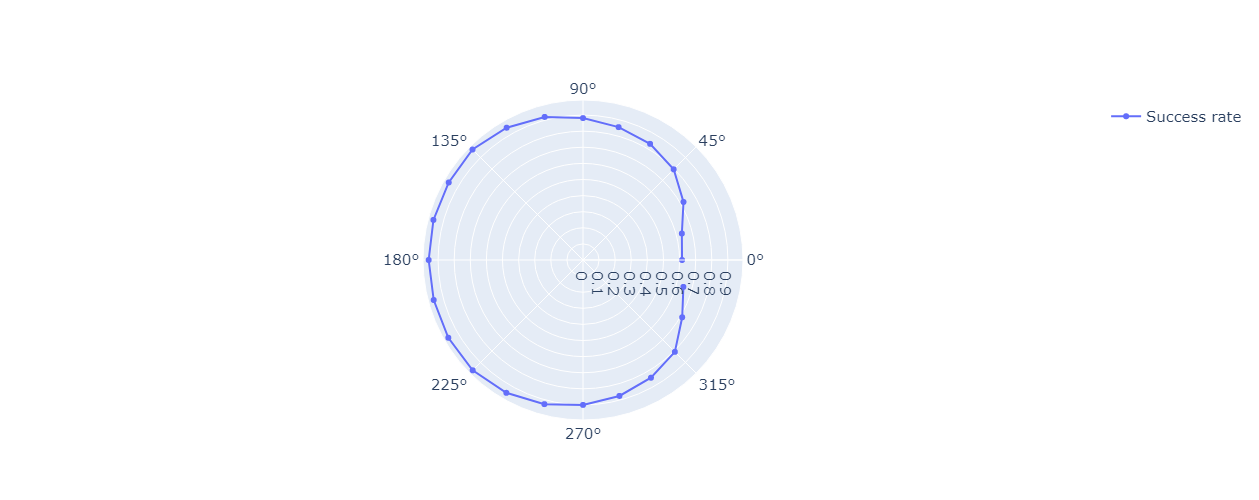

In [134]:
angle_success = pd.DataFrame({"Group":[group for group in get_angle_groups(n_angle)], "Successful": [0] * n_angle, "Unsuccessful": [0] * n_angle})

for row_id, row in dataset_filtered.iterrows():
    if row.outcome_complete == 1:
        angle_success.loc[angle_success[angle_success.Group == (row.pass_angle_discretized)].index, "Successful"] += 1
    else:
        angle_success.loc[angle_success[angle_success.Group == (row.pass_angle_discretized)].index, "Unsuccessful"] += 1
        
angle_success.loc[:,"Success rate"] = angle_success.Successful/(angle_success.Successful+angle_success.Unsuccessful)
        
fig = go.Figure(
    data=[
        go.Scatterpolar(r=angle_success["Success rate"], theta=angle_success.Group, name="Success rate", mode="lines+markers")
    ],
    layout=go.Layout(
        polar={"radialaxis": {"visible": True, "tickmode": "array"}},
        showlegend=True,
        width=500,
        height=500
    )
)
fig.update_layout(font=dict(size=15))

fig.write_image("pass_success_angle.png")
fig.show()

### Height

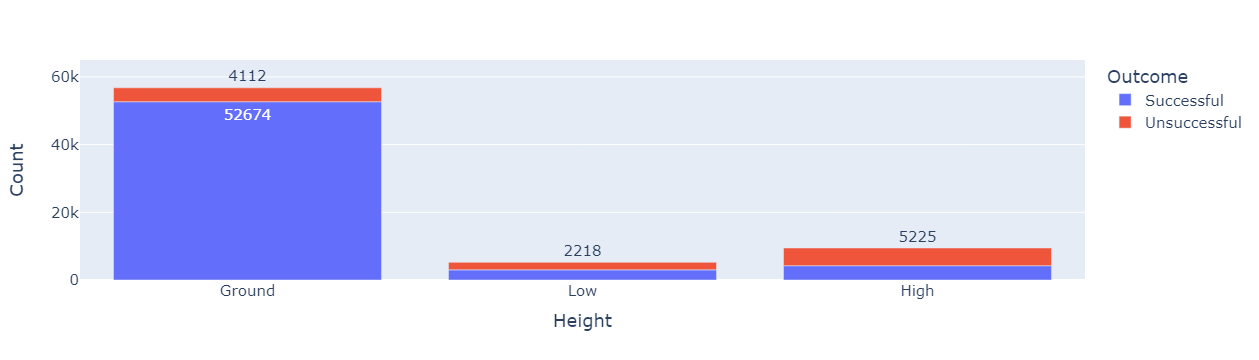

In [154]:
height_success = pd.DataFrame({"Height":["Ground", "Low", "High"] * 2, "Count": [0] * 3 * 2, "Outcome": ["Successful"] * 3 + ["Unsuccessful"] * 3})

for row_id, row in dataset_filtered.iterrows():
    if row.pass_height_ground == 1:
        height = "Ground"
    elif row.pass_height_low == 1:
        height = "Low"
    else:
        height = "High"
        
    if row.outcome_complete == 1:
        height_success.loc[height_success[(height_success.Height == height) & (height_success.Outcome == "Successful")].index, "Count"] += 1
    else:
        height_success.loc[height_success[(height_success.Height == height) & (height_success.Outcome == "Unsuccessful")].index, "Count"] += 1

fig = px.bar(height_success, x="Height", y="Count", color="Outcome", text="Count", width=500, height=300)
fig.update_layout(font=dict(size=15), uniformtext_minsize=8, uniformtext_mode="hide", yaxis_range=[0,65000])
fig.update_traces(textposition="outside")

fig.write_image("pass_success_height.png")
fig.show()

### Body

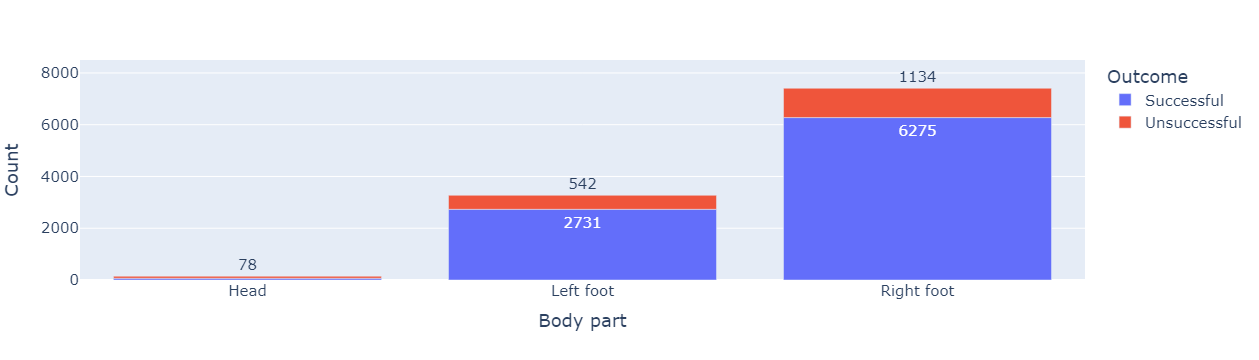

In [169]:
body_success = pd.DataFrame({"Body part":["Head", "Left foot", "Right foot"] * 2, "Count": [0] * 3 * 2, "Outcome": ["Successful"] * 3 + ["Unsuccessful"] * 3})

for row_id, row in test_dataset.iterrows():
    if row.body_head == 1:
        body = "Head"
    elif row.body_left_foot == 1:
        body = "Left foot"
    else:
        body = "Right foot"
        
    if row.outcome_complete == 1:
        body_success.loc[body_success[(body_success["Body part"] == body) & (body_success.Outcome == "Successful")].index, "Count"] += 1
    else:
        body_success.loc[body_success[(body_success["Body part"] == body) & (body_success.Outcome == "Unsuccessful")].index, "Count"] += 1

fig = px.bar(body_success, x="Body part", y="Count", color="Outcome", text="Count", width=500, height=300)
fig.update_layout(font=dict(size=15), uniformtext_minsize=8, uniformtext_mode="hide", yaxis_range=[0,8500])
fig.update_traces(textposition="outside")

fig.write_image("pass_success_body.png")
fig.show()

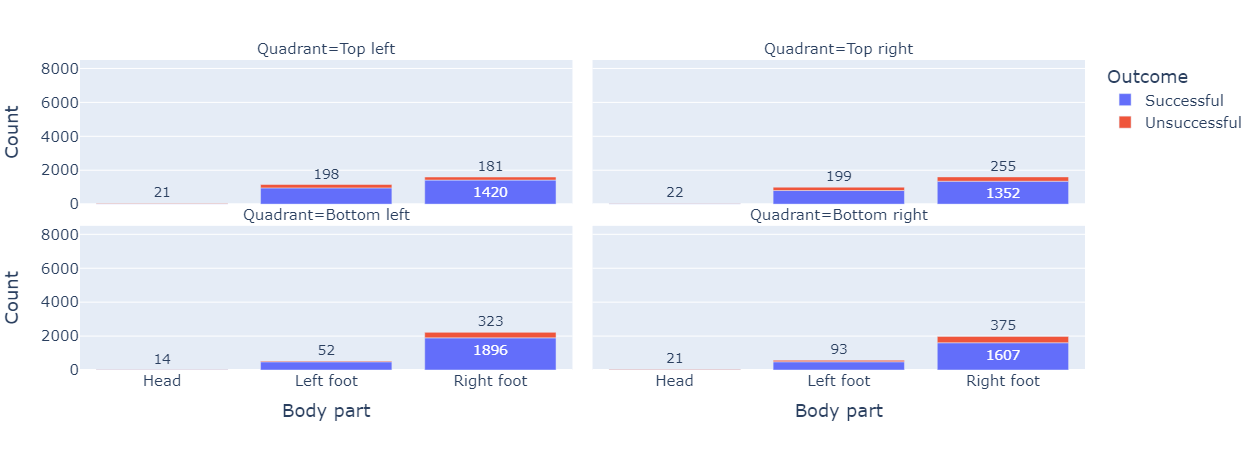

In [168]:
body_success = pd.DataFrame({"Body part":["Head", "Left foot", "Right foot"] * 2 * 4, "Count": [0] * 3 * 2 * 4, 
                             "Outcome": ["Successful"] * 3 * 4 + ["Unsuccessful"] * 3 * 4, 
                             "Quadrant": ["Top left"] * 3 + ["Top right"] * 3 + ["Bottom left"] * 3 + ["Bottom right"] * 3 + 
                            ["Top left"] * 3 + ["Top right"] * 3 + ["Bottom left"] * 3 + ["Bottom right"] * 3})

# display(body_success)

for row_id, row in test_dataset.iterrows():
    if row.body_head == 1:
        body = "Head"
    elif row.body_left_foot == 1:
        body = "Left foot"
    else:
        body = "Right foot"
        
    if row.x < 60: # defense
        if row.y < 40: # top left
            quadrant = "Top left"
        else: # bottom left
            quadrant = "Bottom left"
    else: # offense
        if row.y < 40: # top right
            quadrant = "Top right"
        else: # bottom right
            quadrant = "Bottom right"
        
    if row.outcome_complete == 1:
        body_success.loc[body_success[(body_success["Body part"] == body) & (body_success.Outcome == "Successful") & (body_success.Quadrant == quadrant)].index, "Count"] += 1
    else:
        body_success.loc[body_success[(body_success["Body part"] == body) & (body_success.Outcome == "Unsuccessful") & (body_success.Quadrant == quadrant)].index, "Count"] += 1

fig = px.bar(body_success, x="Body part", y="Count", color="Outcome", text="Count", facet_col="Quadrant", facet_col_wrap=2, width=750, height=450)
fig.update_layout(font=dict(size=15), uniformtext_minsize=10, uniformtext_mode="hide", yaxis_range=[0,8500])
fig.update_traces(textposition="outside")

fig.write_image("pass_success_body_quadrant.png")
fig.show()

## Pass optimization

In [6]:
successful_passes = dataset_filtered[dataset_filtered.outcome_complete == 1]
unsuccessful_passes = dataset_filtered[dataset_filtered.outcome_complete == 0]

display(successful_passes.describe())
display(unsuccessful_passes.describe())

match_id  pass_height_ground  pass_height_low  pass_height_high  \
count  5.990400e+04        59904.000000     59904.000000      59904.000000   
mean   3.814333e+06            0.879307         0.050047          0.070646   
std    2.778532e+04            0.325773         0.218043          0.256235   
min    3.788741e+06            0.000000         0.000000          0.000000   
25%    3.788764e+06            1.000000         0.000000          0.000000   
50%    3.795109e+06            1.000000         0.000000          0.000000   
75%    3.835339e+06            1.000000         0.000000          0.000000   
max    3.857271e+06            1.000000         1.000000          1.000000   

         pass_angle  pass_angle_processed     angle_sin     angle_cos  \
count  59904.000000          59904.000000  59904.000000  59904.000000   
mean       0.026135            178.574716     -0.002680      0.084975   
std        1.684503            107.064579      0.753680      0.651733   
min       -3.137833              0.000000     -1.000000     -1.000000   
25%       -1.402869             80.427675     -0.866025     -0.500000   
50%        0.006211            180.000000      0.000000      0.258819   
75%        1.468935            275.878250      0.707107      0.707107   
max        3.141593            360.000000      1.000000      1.000000   

       body_drop_kick     body_head  body_keeper_arm  body_left_foot  \
count         59904.0  59904.000000          59904.0    59904.000000   
mean              0.0      0.007796              0.0        0.300714   
std               0.0      0.087950              0.0        0.458573   
min               0.0      0.000000              0.0        0.000000   
25%               0.0      0.000000              0.0        0.000000   
50%               0.0      0.000000              0.0        0.000000   
75%               0.0      0.000000              0.0        1.000000   
max               0.0      1.000000              0.0        1.000000   

       body_other  body_right_foot  body_no_touch  outcome_complete  \
count     59904.0     59904.000000        59904.0           59904.0   
mean          0.0         0.685881            0.0               1.0   
std           0.0         0.464168            0.0               0.0   
min           0.0         0.000000            0.0               1.0   
25%           0.0         0.000000            0.0               1.0   
50%           0.0         1.000000            0.0               1.0   
75%           0.0         1.000000            0.0               1.0   
max           0.0         1.000000            0.0               1.0   

            cutback             x             y  pass_angle_discretized  
count  59904.000000  59904.000000  59904.000000            59904.000000  
mean       0.001436     58.067955     39.660731              171.374199  
std        0.037863     24.609801     22.707959              106.910408  
min        0.000000      0.100000      0.100000                0.000000  
25%        0.000000     40.700000     20.000000               75.000000  
50%        0.000000     57.300000     39.400000              165.000000  
75%        0.000000     76.400000     59.400000              270.000000  
max        1.000000    120.000000     80.000000              345.000000

match_id  pass_height_ground  pass_height_low  pass_height_high  \
count  1.155500e+04        11555.000000     11555.000000      11555.000000   
mean   3.818152e+06            0.355863         0.191952          0.452185   
std    2.722840e+04            0.478795         0.393852          0.497730   
min    3.788741e+06            0.000000         0.000000          0.000000   
25%    3.788768e+06            0.000000         0.000000          0.000000   
50%    3.835320e+06            0.000000         0.000000          0.000000   
75%    3.835342e+06            1.000000         0.000000          1.000000   
max    3.857271e+06            1.000000         1.000000          1.000000   

         pass_angle  pass_angle_processed     angle_sin     angle_cos  \
count  11555.000000          11555.000000  11555.000000  11555.000000   
mean      -0.033866            171.487748      0.029830      0.584324   
std        1.051544            138.896645      0.643709      0.493326   
min       -3.126150              0.000000     -1.000000     -1.000000   
25%       -0.695315             33.442950     -0.500000      0.258819   
50%       -0.030665            113.378000      0.000000      0.866025   
75%        0.592909            320.013000      0.500000      0.965926   
max        3.141593            360.000000      1.000000      1.000000   

       body_drop_kick     body_head  body_keeper_arm  body_left_foot  \
count         11555.0  11555.000000          11555.0    11555.000000   
mean              0.0      0.044223              0.0        0.315967   
std               0.0      0.205600              0.0        0.464920   
min               0.0      0.000000              0.0        0.000000   
25%               0.0      0.000000              0.0        0.000000   
50%               0.0      0.000000              0.0        0.000000   
75%               0.0      0.000000              0.0        1.000000   
max               0.0      1.000000              0.0        1.000000   

       body_other  body_right_foot  body_no_touch  outcome_complete  \
count     11555.0     11555.000000        11555.0           11555.0   
mean          0.0         0.601039            0.0               0.0   
std           0.0         0.489706            0.0               0.0   
min           0.0         0.000000            0.0               0.0   
25%           0.0         0.000000            0.0               0.0   
50%           0.0         1.000000            0.0               0.0   
75%           0.0         1.000000            0.0               0.0   
max           0.0         1.000000            0.0               0.0   

            cutback             x            y  pass_angle_discretized  
count  11555.000000  11555.000000  11555.00000            11555.000000  
mean       0.010039     63.653146     41.06521              149.520987  
std        0.099695     32.830379     24.85984              136.068504  
min        0.000000      0.600000      0.10000                0.000000  
25%        0.000000     38.100000     18.20000               30.000000  
50%        0.000000     64.600000     42.10000               90.000000  
75%        0.000000     91.500000     64.60000              300.000000  
max        1.000000    120.000000     79.80000              345.000000

In [101]:
warnings.filterwarnings("ignore") # this suppresses a pandas warning here, can be dangerous

def optimize_pass(row, model, allowed_angles, allowed_heights, decision_threshold, device=device):
    row_filtered = filter_columns(row.to_frame().transpose(), columns_to_remove_later)
    original_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=row_filtered, position_tensors_folder=position_tensors_folder), batch_size=1, shuffle=False)
    positions, features, labels = next(iter(original_dataloader))
    positions, features, labels = positions.to(device), features.to(device), labels.to(device).to(torch.float32)
    original_prediction = max(min((model(positions=positions, features=features)).cpu().detach().item(), 1), 0)
    original_label = 1 if original_prediction > decision_threshold else 0
    
    
    original_angle_discretized = row.pass_angle_discretized
    if row.pass_height_ground == 1:
        original_height = "pass_height_ground"
    elif row.pass_height_low == 1:
        original_height = "pass_height_low"
    else:
        original_height = "pass_height_high"

    experiments = pd.concat([row.to_frame()] * len(allowed_angles) * 3, axis=1, ignore_index=True).transpose()
    # display(experiments)
    # print(experiments.shape)
    # break
    experiments.reset_index(drop=True, inplace=True)
    experiments.pass_height_ground = 0
    experiments.pass_height_low = 0
    experiments.pass_height_high = 0
    
    i = 0
    for angle in allowed_angles:
        for height in allowed_heights:
            experiments.loc[i, ["pass_angle_processed"]] = angle
            experiments.loc[i, [height]] = 1
            i += 1

    if allowed_angles:
        experiments.loc[:,["angle_sin"]] = [round(np.sin(np.deg2rad(angle)), 6) for angle in experiments.pass_angle_processed]
        experiments.loc[:,["angle_cos"]] = [round(np.cos(np.deg2rad(angle)), 6) for angle in experiments.pass_angle_processed]
    
    tried_angles = experiments.pass_angle_processed.values

    # Removing columns that were needed up until now but not needed for the model
    experiments = filter_columns(experiments, columns_to_remove_later)

    experiments_dataloader = torch.utils.data.DataLoader(PassesDataset(dataset=experiments, position_tensors_folder=position_tensors_folder), batch_size=experiments.shape[0], shuffle=False)
    positions, features, labels = next(iter(experiments_dataloader))

    positions, features, labels = positions.to(device), features.to(device), labels.to(device).to(torch.float32)
    predicted = (model(positions=positions, features=features)).cpu().detach()
    best_index = torch.argmax(predicted, dim=None).item()
    best_outcome = max(min(predicted[best_index].item(), 1), 0)
    best_label = 1 if best_outcome > decision_threshold else 0
    
    best_move_angle_discretized = tried_angles[best_index]
    if experiments.loc[best_index, "pass_height_ground"] == 1:
        best_move_height = "pass_height_ground"
    elif experiments.loc[best_index, "pass_height_low"] == 1:
        best_move_height = "pass_height_low"
    else:
        best_move_height = "pass_height_high"
        
    if (original_angle_discretized == best_move_angle_discretized) and (original_height == best_move_height):
        changed = False
    else:
        changed = True
        
    return {"Original": {"Angle": original_angle_discretized, "Height": (original_height.split("_")[-1]).title(), 
                         "Prediction": original_prediction, "Predicted label": original_label}, 
            "Optimized": {"Angle": best_move_angle_discretized, "Height": (best_move_height.split("_")[-1]).title(), 
                          "Prediction": best_outcome, "Predicted label": best_label}, 
            "Changed": changed,
            "Label": row.outcome_complete}

def get_recommendations(model, dataset, allowed_angles, allowed_heights, decision_threshold, device=device):
    model.to(device)
    with torch.no_grad():
        model.eval()
        optimal_decision_counter = 0
        impossible_passes = 0
        sankey_data = dict()
        for row_id, row in tqdm.tqdm(dataset.iterrows(), total=dataset.shape[0]):
            optimization = optimize_pass(row, model, allowed_angles, allowed_heights, decision_threshold, device)
            if not optimization["Changed"]:
                optimal_decision_counter += 1
            if optimization["Optimized"]["Predicted label"] == 0:
                impossible_passes += 1
            
            source = str(optimization["Original"]["Angle"]) + " - " + optimization["Original"]["Height"]
            target = str(optimization["Optimized"]["Angle"]) + " - " + optimization["Optimized"]["Height"]
            
            if source not in sankey_data:
                sankey_data[source] = dict()
            
            if target not in sankey_data[source]:
                sankey_data[source][target] = 0
                
            sankey_data[source][target] += 1
            # print(optimization)
            
        # source_nodes = {"Node": [], "Color": []}
        # target_nodes = source_nodes.copy()
        nodes = {"Node": [], "Color": []}
        
        sankey_df = {"Decision": [], "Suggestion": [], "Count": []}
        for source, targets in sankey_data.items():
            if source not in nodes["Node"]:
                nodes["Node"].append(f"Decision: {source}")
                if "Ground" in source:
                    nodes["Color"].append("#0D5C75")
                elif "Low" in source:
                    nodes["Color"].append("#199FB1")
                else:
                    nodes["Color"].append("#A5D1E1")
            for target, count in targets.items():
                if target not in nodes["Node"]:
                    nodes["Node"].append(f"Suggestion: {target}")
                    if "Ground" in target:
                        nodes["Color"].append("#0D5C75")
                    elif "Low" in target:
                        nodes["Color"].append("#199FB1")
                    else:
                        nodes["Color"].append("#A5D1E1")
                sankey_df["Decision"].append(f"Decision: {source}")
                sankey_df["Suggestion"].append(f"Suggestion: {target}")
                sankey_df["Count"].append(count)
                
        # all_nodes = source_nodes.copy()
        # all_nodes["Node"].extend(target_nodes["Node"])
        # all_nodes["Color"].extend(target_nodes["Color"])
                
        sankey_df = pd.DataFrame(sankey_df, columns=sankey_df.keys())
        sankey_df.loc[:, "Color"] = ["#96e5b8" if sankey_df.loc[i, "Decision"].split("Decision: ") == sankey_df.loc[i, "Suggestion"].split("Suggestion: ") else "#f3a59d" for i in range(sankey_df.shape[0])]
        # display(sankey_df)
        
        # print([target_nodes["Node"][::-1].index(t) for t in sankey_df["Suggestion"]])
        # print([all_nodes["Node"][all_nodes["Node"][::-1].index(t)] for t in sankey_df["Suggestion"]])
        # print(nodes["Color"])
        
        fig = go.Figure(data=[go.Sankey(
            node = dict(
              pad = 15,
              thickness = 15,
              line = dict(color = "black", width = 0.5),
              label =  nodes["Node"],
              color =  nodes["Color"]
            ),
            link = dict(
              source = [nodes["Node"].index(s) for s in sankey_df["Decision"]],
              target = [nodes["Node"].index(t) for t in sankey_df["Suggestion"]],
              value = sankey_df["Count"],
              label = sankey_df["Suggestion"],
              color = sankey_df["Color"]
            )
        )])

        fig.update_layout(font_size=20, width=1000, height=600)
        # fig.show()
        
        print(f"Optimal decision rate: {optimal_decision_counter/dataset.shape[0]}")
        print(f"Impossible passes: {impossible_passes/dataset.shape[0]}")
        return sankey_df, fig
            

decision_threshold = 0.6099999999999998

### Unsuccessful passes

Here I make suggestions for the unsuccessful passes.

100%|██████████████████████████████████████████████████████████████████████████| 11555/11555 [1:02:47<00:00,  3.07it/s]

Optimal decision rate: 0.01549112938122025
Impossible passes: 0.08541756815231502


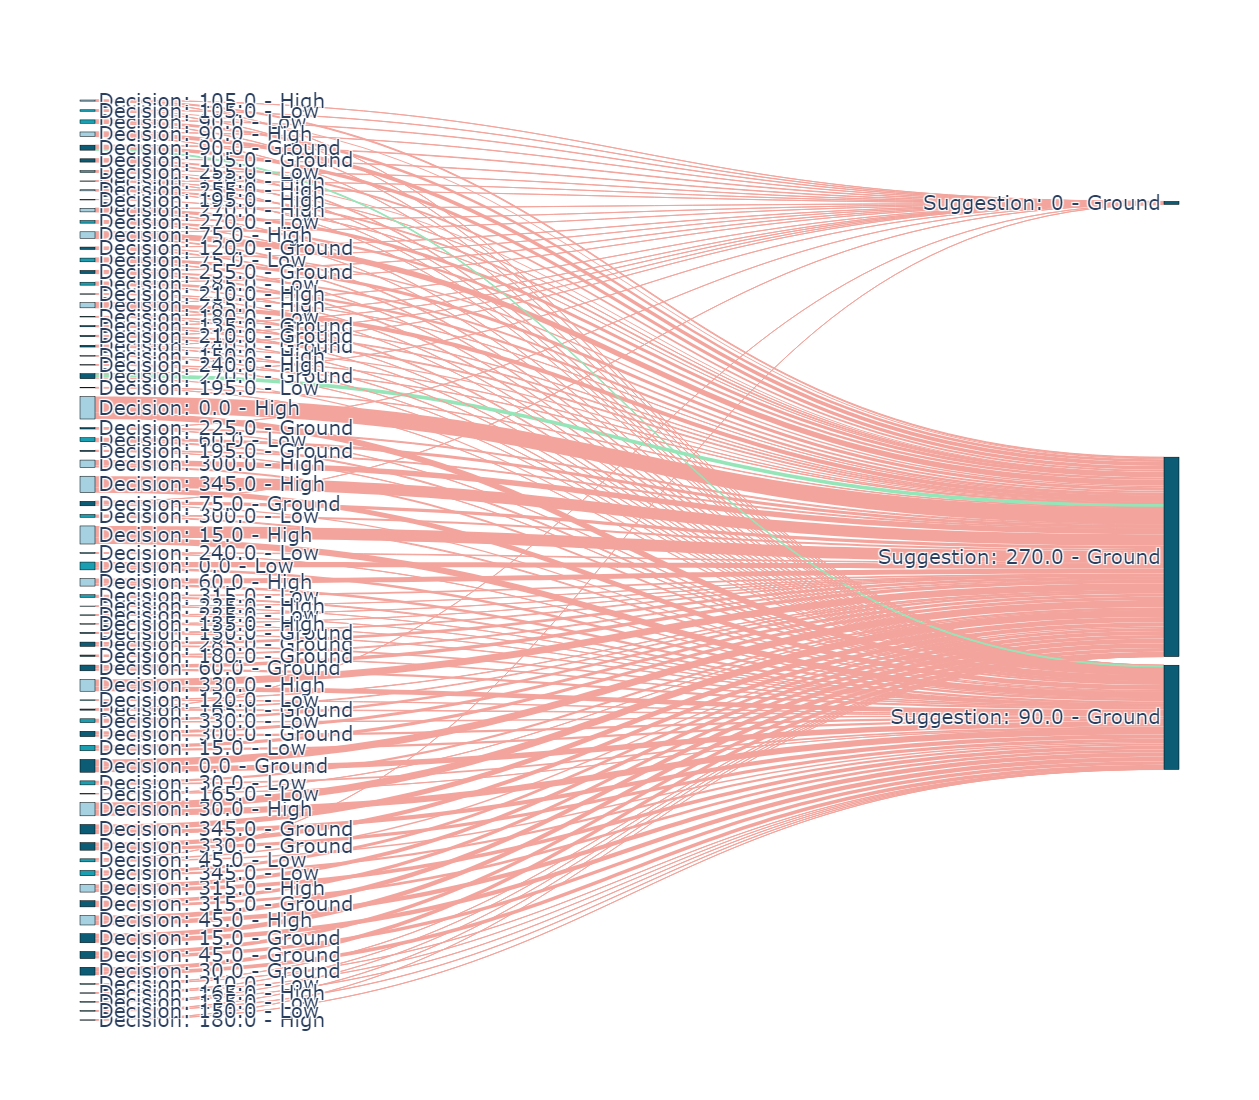

In [104]:
allowed_angles = [angle for angle in get_angle_groups(n_angle) if angle <= 90 or (270 <= angle <= 360)]
allowed_heights = ["pass_height_ground", "pass_height_low", "pass_height_high"]

suggestions_unsuccessful, suggestions_unsuccessful_fig = get_recommendations(model, unsuccessful_passes.iloc[:,:], allowed_angles, allowed_heights, decision_threshold)

# Optimal decision rate: 0.01549112938122025
# Impossible passes: 0.08541756815231502

suggestions_unsuccessful_fig.update_layout(height=1100)
suggestions_unsuccessful_fig.show()
suggestions_unsuccessful_fig.write_image("pass_suggestions_unsuccessful.png")

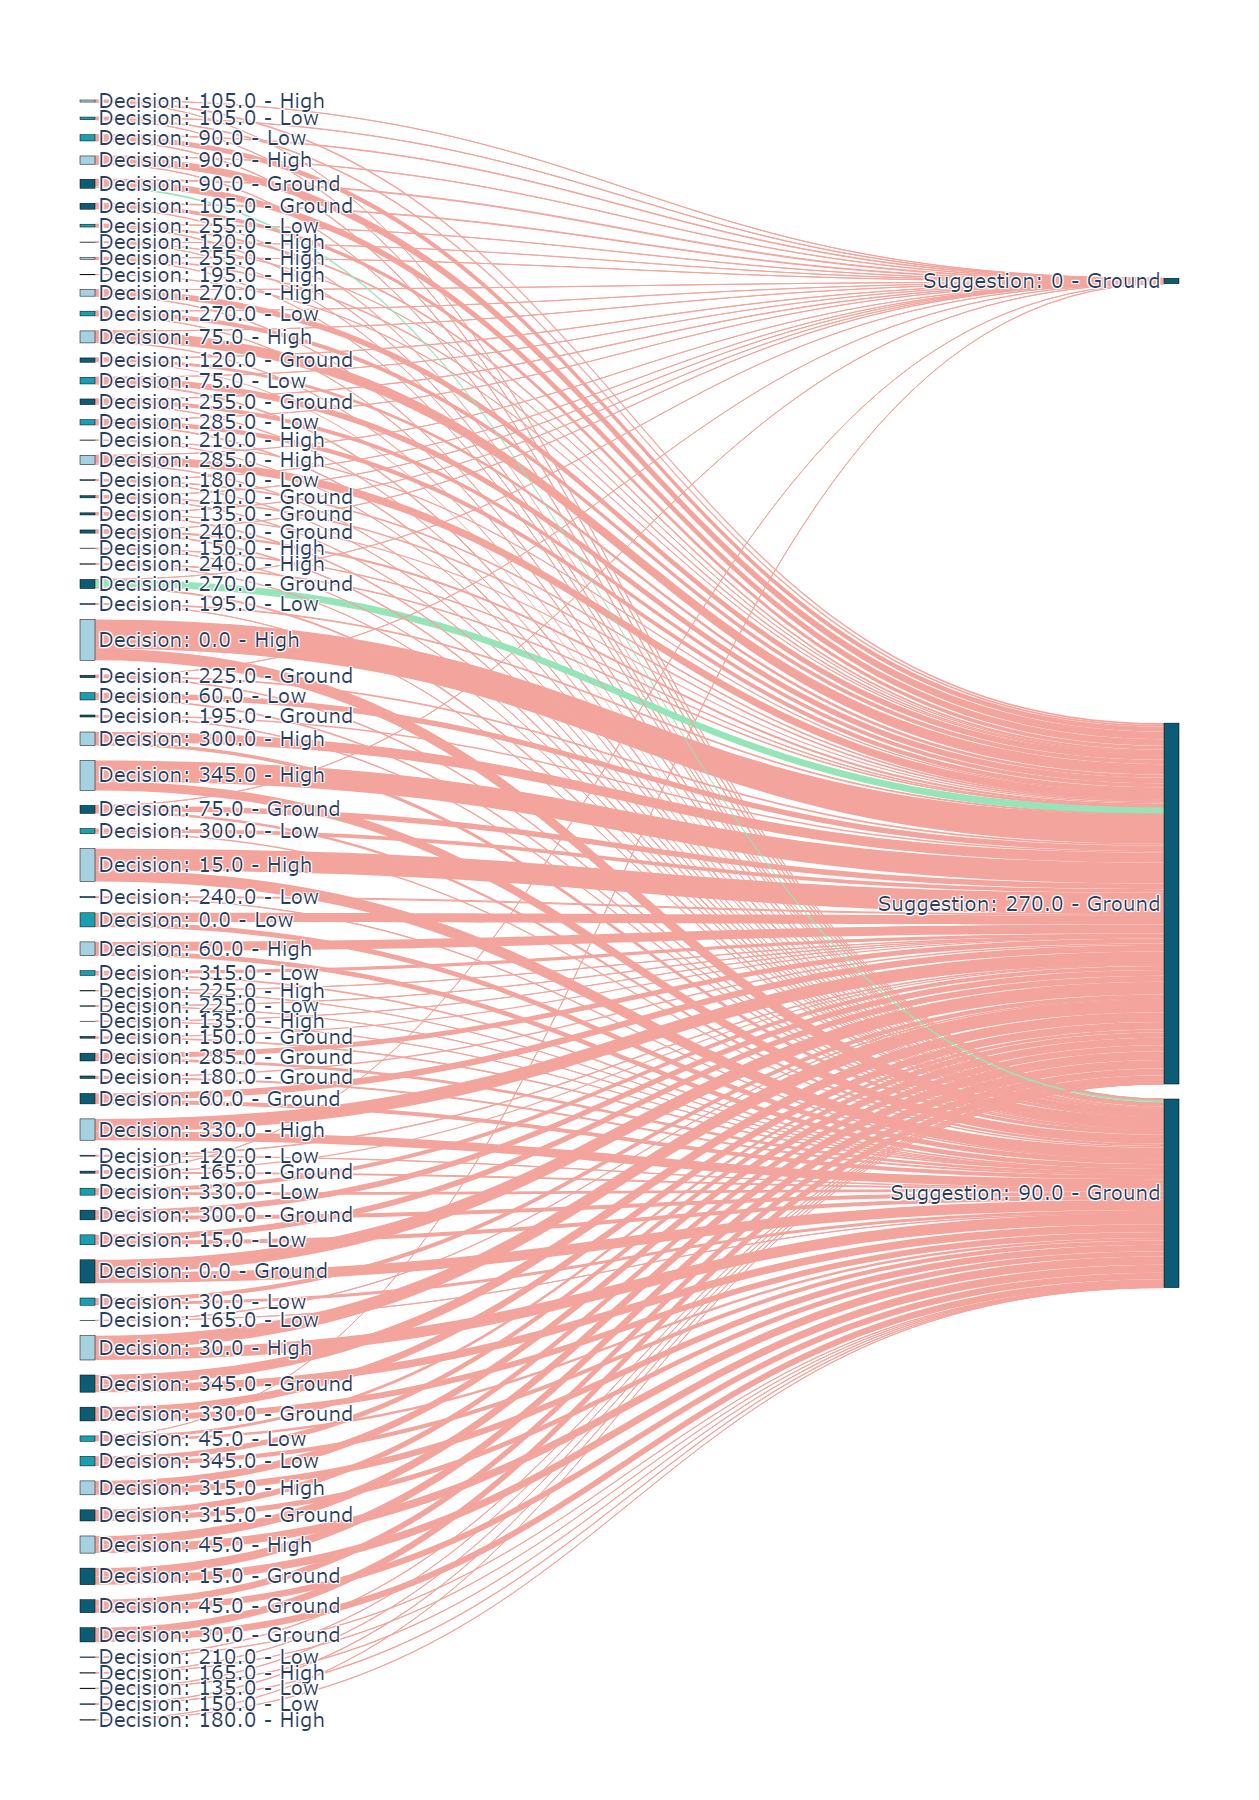

In [115]:
suggestions_unsuccessful_fig.update_layout(height=1800, width=800)
suggestions_unsuccessful_fig.show()
suggestions_unsuccessful_fig.write_image("pass_suggestions_unsuccessful.png")

### Successful passes

Here I make suggestions for the successful passes.

100%|██████████████████████████████████████████████████████████████████████████| 59904/59904 [5:59:12<00:00,  2.78it/s]

Optimal decision rate: 0.05543870192307692
Impossible passes: 0.009982638888888888


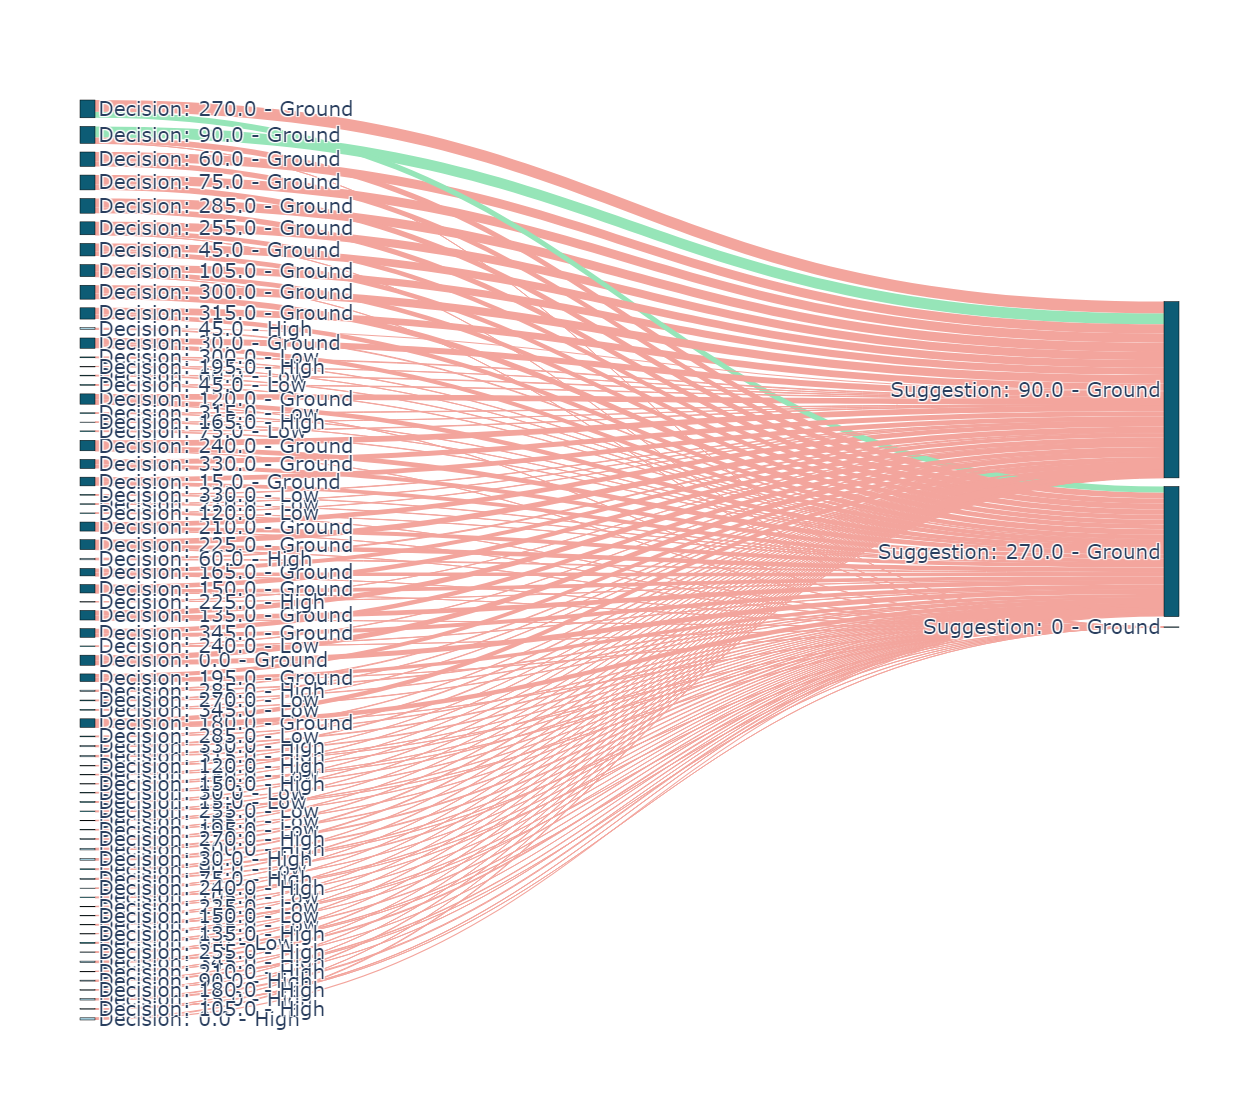

In [105]:
suggestions_successful, suggestions_successful_fig = get_recommendations(model, successful_passes.iloc[:,:], allowed_angles, allowed_heights, decision_threshold)

# Optimal decision rate: 0.05543870192307692
# Impossible passes: 0.009982638888888888

# suggestions_successful_fig = suggestions_successful

suggestions_successful_fig.update_layout(height=1100, width=750)
suggestions_successful_fig.show()
suggestions_successful_fig.write_image("pass_suggestions_successful.png")

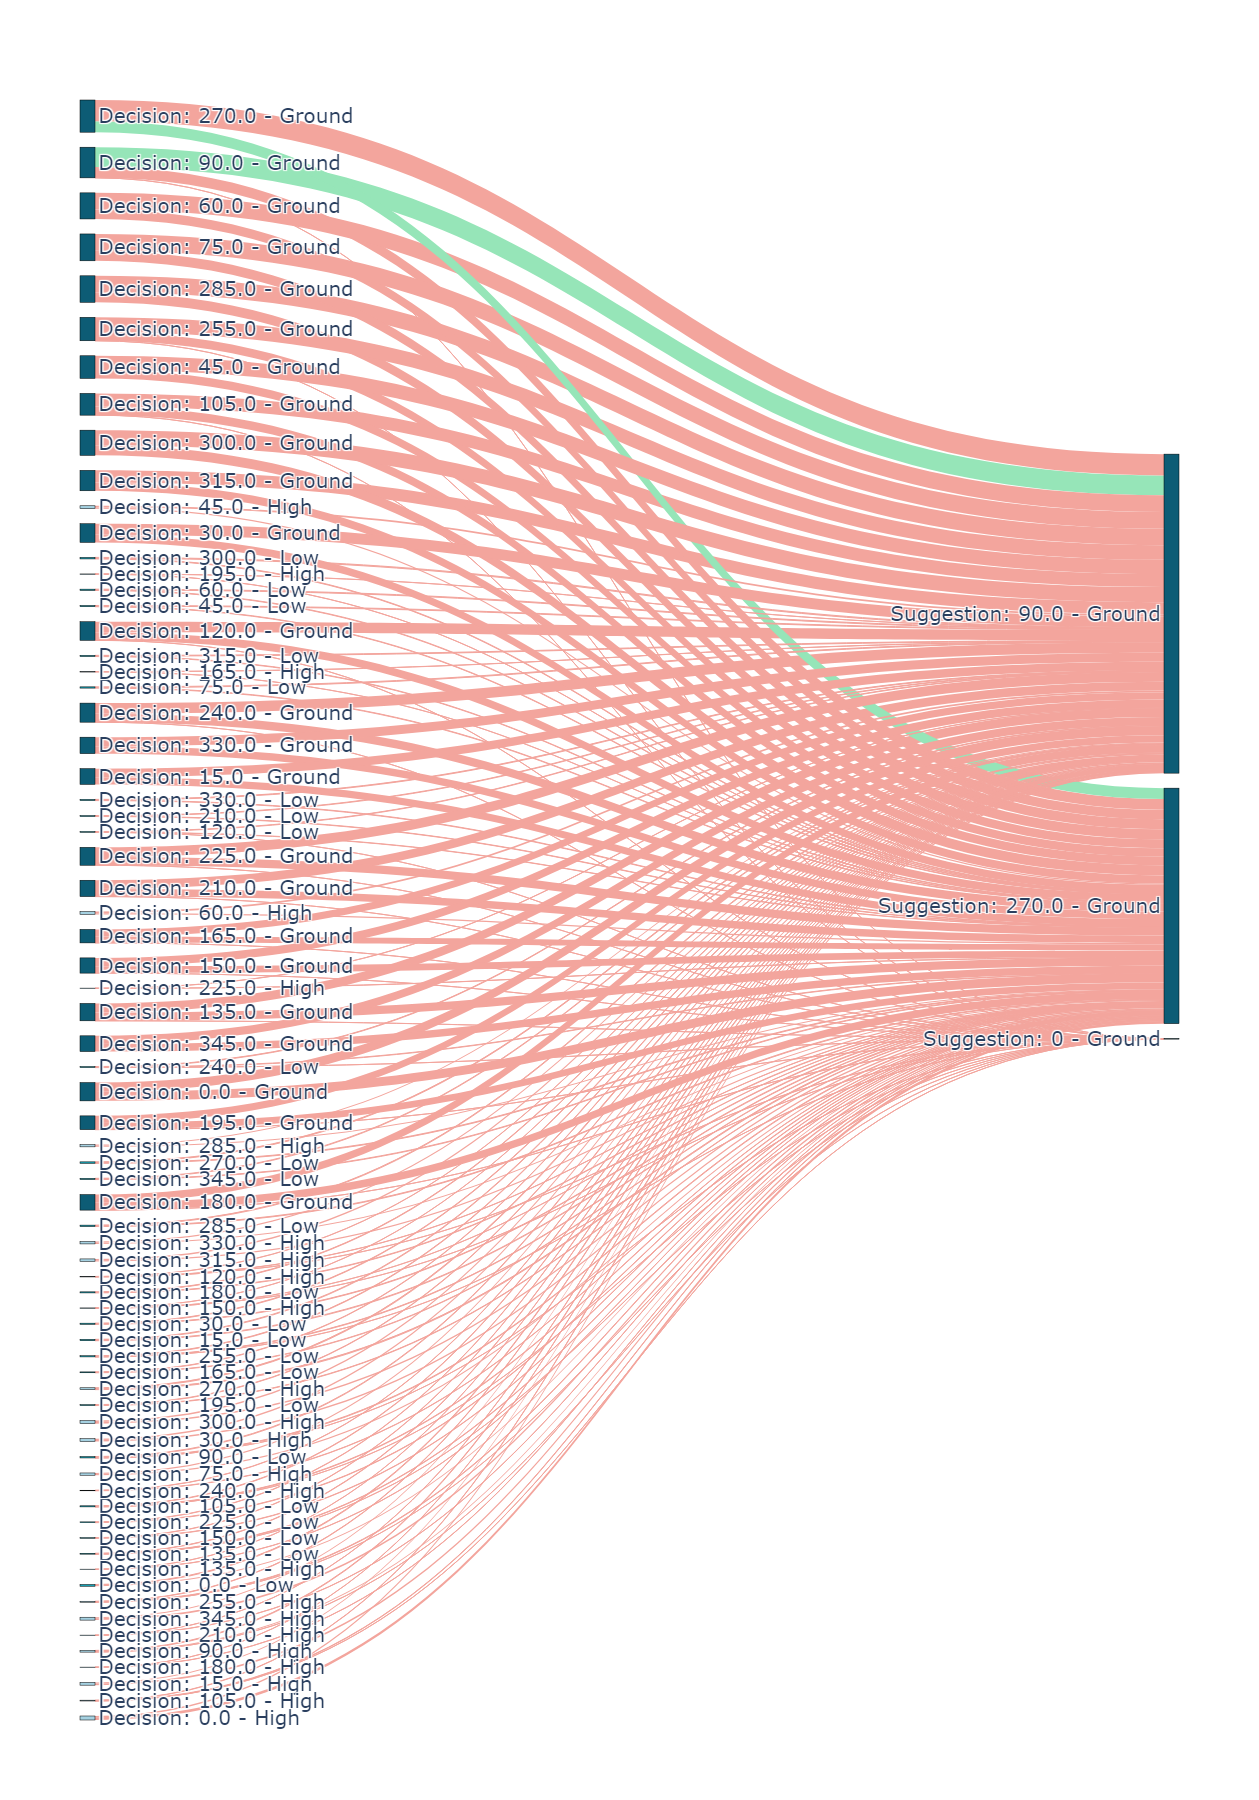

In [114]:
suggestions_successful_fig.update_layout(height=1800, width=800)
suggestions_successful_fig.show()
suggestions_successful_fig.write_image("pass_suggestions_successful.png")